### Contributors
AmirMohammad Bandari (401110278) & Pouria Mahmoudkhan (401110289)

### Including Libraries

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter

# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Phase 1: Preparing Data & EDA

downloading data in `./data` folder and splitting it into `train`, `validation`, and `test`:

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

data_root = './data'
train_full = datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root=data_root, train=False, download=True, transform=transform)

n_train = int(0.9 * len(train_full))
n_val = len(train_full) - n_train
train_ds, val_ds = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(seed))

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

len(train_ds), len(val_ds), len(test_ds), train_ds[0][0].shape

(54000, 6000, 10000, torch.Size([1, 28, 28]))

sanity: show a batch 25 images with labels

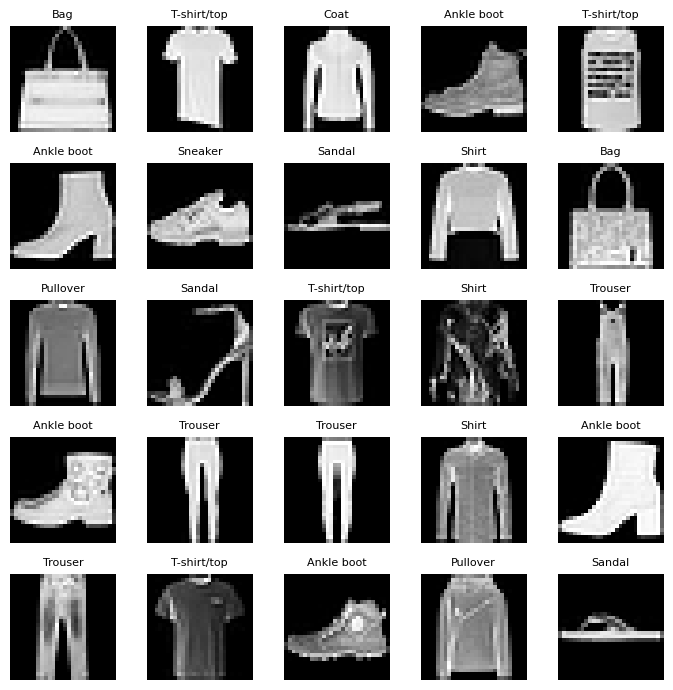

In [3]:
classes = train_full.classes
x, y = next(iter(train_loader))
x = x[:25]
y = y[:25]

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x[i].squeeze(0), cmap='gray')
    plt.title(classes[int(y[i])], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

EDA: class distribution in training set

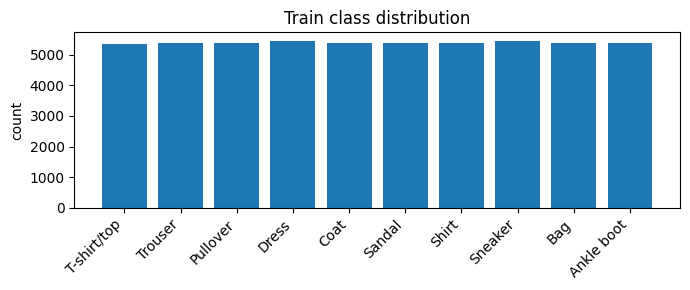

In [4]:
train_labels = [int(train_full.targets[i]) for i in train_ds.indices]
cnt = Counter(train_labels)
xs = np.arange(10)
vals = np.array([cnt[i] for i in xs])

plt.figure(figsize=(7,3))
plt.bar(xs, vals)
plt.xticks(xs, classes, rotation=45, ha='right')
plt.ylabel('count')
plt.title('Train class distribution')
plt.tight_layout()
plt.show()

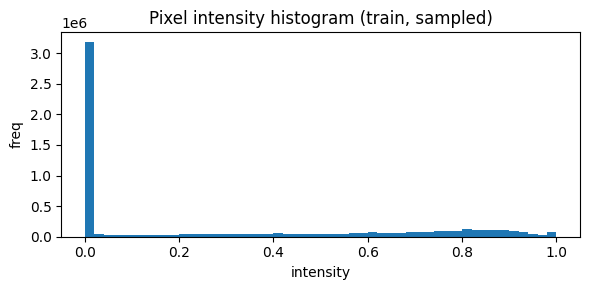

In [5]:
# pixel intensity histogram (sampled for speed)
def sample_pixels(loader, max_batches=80):
    px = []
    for i, (x, _) in enumerate(loader):
        px.append(x.view(-1).cpu().numpy())
        if i+1 >= max_batches:
            break
    px = np.concatenate(px, axis=0)
    return px

px = sample_pixels(train_loader, max_batches=60)
plt.figure(figsize=(6,3))
plt.hist(px, bins=50)
plt.title('Pixel intensity histogram (train, sampled)')
plt.xlabel('intensity')
plt.ylabel('freq')
plt.tight_layout()
plt.show()

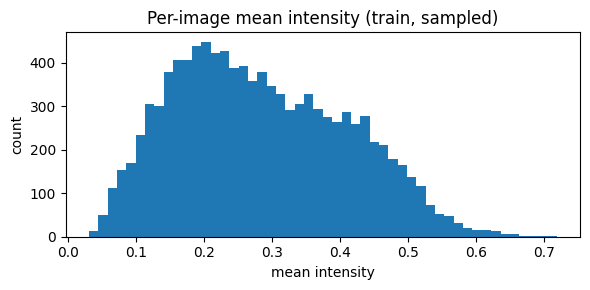

In [6]:
# image-level histogram: mean pixel intensity per image (sampled)
means = []
for i, (x, _) in enumerate(train_loader):
    means.append(x.view(x.size(0), -1).mean(dim=1).cpu().numpy())
    if i >= 80:
        break
means = np.concatenate(means, axis=0)

plt.figure(figsize=(6,3))
plt.hist(means, bins=50)
plt.title('Per-image mean intensity (train, sampled)')
plt.xlabel('mean intensity')
plt.ylabel('count')
plt.tight_layout()
plt.show()

## Helpers
here we are defining some helper functions:
- `to_img_grid` gets a tensor in input and view it as a grid of images, it helps in demonstrations
- `evaluate_vae` abstracts away the of evaluation process of our models (they all use a same function)
- `train_vae` abstracts away the training process of our models (they all use a same function)

In [7]:
def to_img_grid(x, nrow, ncol, figsize=(10,4), title=None):
    x = x.detach().cpu()
    plt.figure(figsize=figsize)
    for i in range(nrow*ncol):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(x[i].squeeze(0), cmap='gray')
        plt.axis('off')
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def evaluate_vae(model, loader, beta=1.0):
    model.eval()
    rec_sum, kld_sum, total_sum, n = 0.0, 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        out = model(x)
        x_hat, mu, logvar = out["x_hat"], out["mu"], out["logvar"]
        rec = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        total = rec + beta * kld
        rec_sum += rec.item()
        kld_sum += kld.item()
        total_sum += total.item()
        n += x.size(0)
    return {
        "recon_per_img": rec_sum / n,
        "kld_per_img": kld_sum / n,
        "total_per_img": total_sum / n
    }

def train_vae(model, train_loader, val_loader, epochs=10, lr=2e-3, beta=1.0, warmup_epochs=0):
    model.to(device)
    opt = Adam(model.parameters(), lr=lr)
    hist = {"train_total":[], "val_total":[], "train_rec":[], "train_kld":[], "val_rec":[], "val_kld":[]}
    for ep in range(1, epochs+1):
        model.train()
        rec_sum, kld_sum, tot_sum, n = 0.0, 0.0, 0.0, 0
        if warmup_epochs > 0:
            beta_ep = beta * min(1.0, ep / warmup_epochs)
        else:
            beta_ep = beta
        for x, _ in train_loader:
            x = x.to(device)
            out = model(x)
            x_hat, mu, logvar = out["x_hat"], out["mu"], out["logvar"]
            rec = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = rec + beta_ep * kld
            opt.zero_grad()
            loss.backward()
            opt.step()
            rec_sum += rec.item()
            kld_sum += kld.item()
            tot_sum += loss.item()
            n += x.size(0)

        tr = {"recon_per_img": rec_sum/n, "kld_per_img": kld_sum/n, "total_per_img": tot_sum/n}
        va = evaluate_vae(model, val_loader, beta=beta)
        hist["train_total"].append(tr["total_per_img"])
        hist["val_total"].append(va["total_per_img"])
        hist["train_rec"].append(tr["recon_per_img"])
        hist["train_kld"].append(tr["kld_per_img"])
        hist["val_rec"].append(va["recon_per_img"])
        hist["val_kld"].append(va["kld_per_img"])
        print(f"ep {ep:02d} | beta={beta_ep:.3f} | train total {tr['total_per_img']:.2f} rec {tr['recon_per_img']:.2f} kld {tr['kld_per_img']:.2f} | val total {va['total_per_img']:.2f}")
    return hist


# Phase 2: VAE implementation & quality improvement

### Define VAE Model

In [ ]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        recon = self.decoder(z)
        return recon.view(-1, 1, 28, 28)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Scale x to [0,1] for BCE
    x_scaled = (x + 1.0) / 2.0
    # Reconstruction loss: BCE
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 28*28), x_scaled.view(-1, 28*28), reduction='sum')
    
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return (recon_loss + beta * kld_loss) / x.size(0)

# Instantiate model
latent_dim = 20
vae_base = VAE(latent_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_base.to(device)

# Optimizer
optimizer = Adam(vae_base.parameters(), lr=1e-3)

# Training loop
epochs = 20 
train_losses = []
val_losses = []

for epoch in range(epochs):
    vae_base.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_base(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    vae_base.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon, mu, logvar = vae_base(data)
            val_loss += vae_loss(recon, data, mu, logvar).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

# Plot training curves
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.title('Training Losses')
plt.show()

In [ ]:
# Get some test images
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Reconstruct
vae_base.eval()
with torch.no_grad():
    recon, _, _ = vae_base(test_images)

# Display 20 pairs
plt.figure(figsize=(20, 4))
for i in range(20):
    # Original
    plt.subplot(4, 20, i+1)
    img = test_images[i].cpu().numpy().squeeze() * 0.5 + 0.5  # [-1,1] to [0,1]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Original')
    
    # Recon
    plt.subplot(4, 20, i+21)
    recon_img = recon[i].cpu().numpy().squeeze()  # [0,1] as is
    plt.imshow(recon_img, cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Recon')
plt.show()

In [ ]:
# Sample from standard normal
with torch.no_grad():
    z = torch.randn(50, latent_dim).to(device)
    samples = vae_base.decode(z).cpu().numpy()

# Display
plt.figure(figsize=(10, 10))
for i in range(50):
    plt.subplot(10, 5, i+1)
    img = samples[i].squeeze()  # [0,1] as is
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Compute losses on test
test_recon_loss = 0
test_kld_loss = 0
test_total_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon, mu, logvar = vae_base(data)
        x_scaled = (data + 1.0) / 2.0
        recon_l = F.binary_cross_entropy(recon.view(-1, 28*28), x_scaled.view(-1, 28*28), reduction='mean')
        kld_l = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_l = recon_l + kld_l
        test_recon_loss += recon_l.item()
        test_kld_loss += kld_l.item()
        test_total_loss += total_l.item()
test_recon_loss /= len(test_loader)
test_kld_loss /= len(test_loader)
test_total_loss /= len(test_loader)

print(f'Test Reconstruction Loss: {test_recon_loss:.4f}')
print(f'Test Regularization (KLD) Loss: {test_kld_loss:.4f}')
print(f'Test Total Loss: {test_total_loss:.4f}')

In [ ]:
# Define Convolutional VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_conv = nn.Sequential(
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # [0,1]
        )
    
    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        h = self.enc_fc(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.dec_fc(z)
        recon = self.dec_conv(h)
        return recon
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Instantiate improved model
latent_dim_improved = 32
vae_improved = ConvVAE(latent_dim_improved)
vae_improved.to(device)

# Optimizer
optimizer_improved = Adam(vae_improved.parameters(), lr=1e-3)

# Training loop
train_losses_imp = []
val_losses_imp = []

for epoch in range(epochs):
    vae_improved.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer_improved.zero_grad()
        recon, mu, logvar = vae_improved(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer_improved.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses_imp.append(train_loss)
    
    vae_improved.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon, mu, logvar = vae_improved(data)
            val_loss += vae_loss(recon, data, mu, logvar).item()
    val_loss /= len(val_loader)
    val_losses_imp.append(val_loss)
    
    print(f'Improved Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

# Plot
plt.plot(train_losses_imp, label='Train Imp')
plt.plot(val_losses_imp, label='Val Imp')
plt.legend()
plt.title('Improved Training Losses')
plt.show()

In [ ]:
# Metrics for improved on test
test_recon_loss_imp = 0
test_kld_loss_imp = 0
test_total_loss_imp = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon, mu, logvar = vae_improved(data)
        x_scaled = (data + 1.0) / 2.0
        recon_l = F.binary_cross_entropy(recon.view(-1, 28*28), x_scaled.view(-1, 28*28), reduction='mean')
        kld_l = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_l = recon_l + kld_l
        test_recon_loss_imp += recon_l.item()
        test_kld_loss_imp += kld_l.item()
        test_total_loss_imp += total_l.item()
test_recon_loss_imp /= len(test_loader)
test_kld_loss_imp /= len(test_loader)
test_total_loss_imp /= len(test_loader)

# Table
print('| Model | Recon Loss | KLD Loss | Total Loss |')
print('|-------|------------|----------|------------|')
print(f'| Base  | {test_recon_loss:.4f} | {test_kld_loss:.4f} | {test_total_loss:.4f} |')
print(f'| Imp   | {test_recon_loss_imp:.4f} | {test_kld_loss_imp:.4f} | {test_total_loss_imp:.4f} |')

In [ ]:
# Recon comparison (10 samples)
vae_base.eval()
vae_improved.eval()
with torch.no_grad():
    recon_base, _, _ = vae_base(test_images[:10])
    recon_imp, _, _ = vae_improved(test_images[:10])

plt.figure(figsize=(20, 4))
for i in range(10):
    # Base Recon
    plt.subplot(4, 10, i+1)
    recon_b = recon_base[i].cpu().numpy().squeeze()  # [0,1]
    plt.imshow(recon_b, cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Base Recon')
    
    # Imp Recon
    plt.subplot(4, 10, i+11)
    recon_i = recon_imp[i].cpu().numpy().squeeze()  # [0,1]
    plt.imshow(recon_i, cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Imp Recon')

plt.show()

# Sampling comparison
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    samples_base = vae_base.decode(z).cpu().numpy()
    z_imp = torch.randn(10, latent_dim_improved).to(device)
    samples_imp = vae_improved.decode(z_imp).cpu().numpy()

plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(2, 10, i+1)
    img = samples_base[i].squeeze()  # [0,1]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Base Sample')
    
    plt.subplot(2, 10, i+11)
    img = samples_imp[i].squeeze()  # [0,1]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Imp Sample')
plt.show()


In [ ]:
from torchvision.models import resnet18

class FashionResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = resnet18(weights=None)

        m.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        m.maxpool = nn.Identity()

        m.fc = nn.Identity()
        self.backbone = m
        self.head = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor):
        feats = self.backbone(x)
        logits = self.head(feats)
        return logits, feats
    
checkpoint = torch.load('./classifier/fashion_resnet18_classifier.pt', map_location=device)

if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

classifier = FashionResNet18(num_classes=10).to(device)
classifier.load_state_dict(state_dict, strict=False)
classifier.eval()

num_gen = 10000
batch_size_gen = 128
generated = []

vae_improved.eval()
with torch.no_grad():
    for _ in range((num_gen + batch_size_gen - 1) // batch_size_gen):
        z = torch.randn(batch_size_gen, latent_dim_improved, device=device)
        fake = vae_improved.decode(z)
        generated.append(fake)
        if len(generated) * batch_size_gen >= num_gen:
            break

generated = torch.cat(generated)[:num_gen]

real = []
with torch.no_grad():
    for x, _ in test_loader:
        real.append(x.to(device))
        if len(real) * test_loader.batch_size >= num_gen:
            break

real = torch.cat(real)[:num_gen]
real = (real + 1) / 2   # [0,1]

real_feats = []
fake_feats = []

with torch.no_grad():
    for i in range(0, num_gen, batch_size_gen):
        end = min(i + batch_size_gen, num_gen)
        
        batch_real = real[i:end]
        _, f_real = classifier(batch_real)
        real_feats.append(f_real.cpu())
        
        batch_fake = generated[i:end]
        _, f_fake = classifier(batch_fake)
        fake_feats.append(f_fake.cpu())

real_feats = torch.cat(real_feats).numpy()
fake_feats = torch.cat(fake_feats).numpy()

mu_real = np.mean(real_feats, axis=0)
mu_fake = np.mean(fake_feats, axis=0)

diff = mu_real - mu_fake
diff_sq = np.sum(diff ** 2)

cov_real = np.cov(real_feats, rowvar=False)
cov_fake = np.cov(fake_feats, rowvar=False)

mean_diff = diff_sq

def matrix_sqrt_approx(A):
    eigvals, eigvecs = np.linalg.eig(A)
    sqrt_eig = np.sqrt(np.maximum(eigvals, 0))
    return eigvecs @ np.diag(sqrt_eig) @ eigvecs.T

covmean = matrix_sqrt_approx(cov_real @ cov_fake)

trace_term = np.trace(cov_real + cov_fake - 2 * covmean.real)

fid = mean_diff + trace_term

print(f"FID: {fid:.4f}")

# Phase 3: Controlling latent space

# Phase 4: Image generation with labels

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder (image + label)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28 + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        # Decoder (latent + label)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def one_hot(self, labels):
        return F.one_hot(labels, num_classes=self.num_classes).float()

    def encode(self, x, labels):
        labels = self.one_hot(labels)
        x = torch.cat([x.view(x.size(0), -1), labels], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        labels = self.one_hot(labels)
        z = torch.cat([z, labels], dim=1)
        recon = self.decoder(z)
        return recon.view(-1, 1, 28, 28)

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, labels)
        return recon, mu, logvar

In [ ]:
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    x_scaled = (x + 1.0) / 2.0

    recon_loss = F.binary_cross_entropy(
        recon_x.view(-1, 28*28),
        x_scaled.view(-1, 28*28),
        reduction='sum'
    )

    kld_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return (recon_loss + beta * kld_loss) / x.size(0)


In [ ]:
latent_dim = 20
cvae = CVAE(latent_dim).to(device)
optimizer = Adam(cvae.parameters(), lr=1e-3)

epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    cvae.train()
    train_loss = 0

    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = cvae(data, labels)
        loss = cvae_loss(recon, data, mu, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    cvae.eval()
    val_loss = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)

            recon, mu, logvar = cvae(data, labels)
            val_loss += cvae_loss(recon, data, mu, logvar).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")

In [ ]:
cvae.eval()

num_classes = 10
samples_per_class = 20

fig, axes = plt.subplots(num_classes, samples_per_class,
                         figsize=(samples_per_class, num_classes))

with torch.no_grad():
    for cls in range(num_classes):
        labels = torch.full((samples_per_class,),
                            cls,
                            device=device)

        z = torch.randn(samples_per_class,
                        latent_dim,
                        device=device)

        generated = cvae.decode(z, labels).cpu()

        for i in range(samples_per_class):
            axes[cls, i].imshow(generated[i][0],
                                cmap='gray')
            axes[cls, i].axis('off')

plt.tight_layout()
plt.show()

### Cmp

In [ ]:
def evaluate_test_loss_vae(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(loader)


def evaluate_test_loss_cvae(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, labels in loader:
            x = x.to(device)
            labels = labels.to(device)
            recon, mu, logvar = model(x, labels)
            loss = cvae_loss(recon, x, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
vae_test_loss = evaluate_test_loss_vae(vae_base, test_loader)
cvae_test_loss = evaluate_test_loss_cvae(cvae, test_loader)

print("=== Test Loss Comparison ===")
print(f"VAE  test loss: {vae_test_loss:.4f}")
print(f"CVAE test loss: {cvae_test_loss:.4f}")


In [ ]:
def compare_reconstruction_test(vae, cvae, loader, n=8):

    vae.eval()
    cvae.eval()

    x, labels = next(iter(loader))
    x = x[:n].to(device)
    labels = labels[:n].to(device)

    with torch.no_grad():
        recon_vae, _, _ = vae(x)
        recon_cvae, _, _ = cvae(x, labels)

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))

    for i in range(n):
        axes[0, i].imshow(x[i][0].cpu(), cmap='gray')
        axes[0, i].set_title(class_names[labels[i]])
        axes[0, i].axis('off')

        axes[1, i].imshow(recon_vae[i][0].cpu(), cmap='gray')
        axes[1, i].set_title("VAE")
        axes[1, i].axis('off')

        axes[2, i].imshow(recon_cvae[i][0].cpu(), cmap='gray')
        axes[2, i].set_title("CVAE")
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("VAE")
    axes[2, 0].set_ylabel("CVAE")

    plt.tight_layout()
    plt.show()


compare_reconstruction_test(vae_base, cvae, test_loader)


In [ ]:
def generate_per_class(cvae, latent_dim, samples=10):

    cvae.eval()

    fig, axes = plt.subplots(10, samples,
                             figsize=(samples, 10))

    with torch.no_grad():
        for cls in range(10):

            labels = torch.full(
                (samples,),
                cls,
                dtype=torch.long,
                device=device
            )

            z = torch.randn(samples,
                            latent_dim,
                            device=device)

            imgs = cvae.decode(z, labels)

            for i in range(samples):
                axes[cls, i].imshow(
                    imgs[i][0].cpu(),
                    cmap='gray'
                )
                axes[cls, i].axis('off')

            axes[cls, 0].set_ylabel(class_names[cls])

    plt.tight_layout()
    plt.show()


generate_per_class(cvae, latent_dim)


In [ ]:
def compare_sampling_models(vae, cvae, latent_dim, n=10):

    vae.eval()
    cvae.eval()

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    with torch.no_grad():

        z = torch.randn(n, latent_dim, device=device)

        # VAE sampling
        vae_imgs = vae.decode(z)

        # CVAE sampling (random labels)
        labels = torch.randint(0, 10, (n,),
                               device=device)
        cvae_imgs = cvae.decode(z, labels)

    for i in range(n):
        axes[0, i].imshow(vae_imgs[i][0].cpu(),
                          cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(cvae_imgs[i][0].cpu(),
                          cmap='gray')
        axes[1, i].set_title(class_names[labels[i]])
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("VAE")
    axes[1, 0].set_ylabel("CVAE")

    plt.tight_layout()
    plt.show()


compare_sampling_models(vae_base, cvae, latent_dim)


# Phase 5: Report